In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import tailer
import os
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
factors = ["BHLHE40", "CEBPB", "CTCF", "E2F4", "EBF1", "ELF1", "ELK1", "ETS1", "FOS", "IRF4", "JunD", "Max", "MEF2A", "MEF2C", "Mxi1", "NFIC", "NFKB", "NFYA", "NFYB", "Nrf1", "NRSF", "PAX5", "PBX3", "POU2F2", "PU1", "RFX5", "RUNX3", "SP1", "SRF", "STAT1", "STAT3", "TCF3", "USF1", "USF2", "YY1", "ZBTB33", "ZEB1", "Znf143"]
rank_perc = [950, 990, 995]

In [3]:
factordata = {}
DIR="/storage/pandaman/project/singletons/AgentBind/"
for f in factors:
    # load data
    fdata = pd.read_csv(os.path.join(DIR, f, "factor_singletons_r2.tab"), sep="\t", skiprows=1,
                            names=["chrom","start", "end", "ref", "AC", "AN",
                                   "raw.score","snr.score","rank","core"])
    fdata = fdata[~np.isnan(fdata["raw.score"])]
    fdata = fdata[~np.isnan(fdata["snr.score"])]
    fdata["factor"] = f
    factordata[f] = fdata
    print (f)

BHLHE40
CEBPB
CTCF
E2F4
EBF1
ELF1
ELK1
ETS1
FOS
IRF4
JunD
Max
MEF2A
MEF2C
Mxi1
NFIC
NFKB
NFYA
NFYB
Nrf1
NRSF
PAX5
PBX3
POU2F2
PU1
RFX5
RUNX3
SP1
SRF
STAT1
STAT3
TCF3
USF1
USF2
YY1
ZBTB33
ZEB1
Znf143


In [4]:
for f in factors:
    factordata[f]["sing"] = (factordata[f]["AC"] == 1) | \
        ((factordata[f]["AN"] - factordata[f]["AC"]) == 1)

In [5]:
print (factordata["CTCF"])

        chrom      start        end ref   AC     AN     raw.score  snr.score  \
0        chr1     237913     237914   G    2  10760  1.283072e-06   0.135966   
1        chr1     238035     238036   A    1  10582  6.602144e-07   0.081386   
2        chr1     238142     238143   A    1  10396  5.510160e-06   0.583907   
3        chr1     238163     238164   G    1  10420  5.339870e-06   0.658260   
4        chr1     521647     521648   T    1   9124  2.083952e-05   0.766299   
...       ...        ...        ...  ..  ...    ...           ...        ...   
1435333  chrX  155258832  155258833   C    3   1036  1.791923e-06   0.199641   
1435334  chrX  155258836  155258837   C    1   1216  6.151296e-07   0.068532   
1435335  chrX  155258994  155258995   G    4   1240  3.141517e-06   0.350001   
1435336  chrX  155259032  155259033   C    1   2694  7.449523e-07   0.082996   
1435337  chrX  155259047  155259048   C  157   1256  1.081003e-07   0.012044   

          rank  core factor   sing  
0 

In [6]:
data = []

for f in factors:
    d = []
    fd = factordata[f]
    
    # Get pval for core
    p_all = np.mean(fd["sing"])
    p_core = np.mean(fd[fd["core"]>0]["sing"])
    n_all = fd.shape[0]
    n_core = fd[fd["core"]>0].shape[0]
    d = [f, p_all, p_core, n_all, n_core]
    n_not_core = n_all-n_core
    p_not_core = (p_all*n_all-p_core*n_core)/(n_not_core)
    se_core = np.sqrt(p_all*(1-p_all)*(1.0/n_core+1.0/n_not_core))
    pval_core = 1-scipy.stats.norm.cdf((p_core-p_not_core)/se_core)
    d.append(pval_core)
    
    for i in range(len(rank_perc)):
        rk = (fd[fd["rank"]>=rank_perc[i]]["sing"])
        p_rk = np.mean(rk)
        diff_p_rk = p_rk - p_all
        err_rk = np.sqrt(p_rk*(1-p_rk)/len(rk))
        n_rk = len(rk)
        n_not_rk = n_all-n_rk
        p_not_rk = (p_all*n_all-np.sum(rk))*1.0/n_not_rk
        # Compute pvals
        se_rk = np.sqrt(p_all*(1-p_all)*(1.0/n_rk+1.0/n_not_rk))
        pval_rk = 1-scipy.stats.norm.cdf((p_rk-p_not_rk)/se_rk)
        # Add data
        d.extend([p_rk, diff_p_rk, err_rk, pval_rk, len(rk)])
    data.append(d)

cols = ["factor","sing.all","sing.core","n.all","n.core","pval.core"]
for i in range(len(rank_perc)):
    cols.extend(["sing.rank.%s"%rank_perc[i], "diff.rank.%s"%rank_perc[i], 
                 "sing.rank.%s.err"%rank_perc[i], "pval.rank.%s"%rank_perc[i],
                "num.%s"%rank_perc[i]])
results = pd.DataFrame(data, columns=cols)
results["sing.all.err"] = results.apply(lambda x: np.sqrt(x["sing.all"]*(1-x["sing.all"])/x["n.all"]), 1)
results["sing.core.err"] = results.apply(lambda x: np.sqrt(x["sing.core"]*(1-x["sing.core"])/x["n.core"]), 1)

In [7]:
results[["factor","sing.all","sing.rank.950","sing.rank.990","sing.rank.995"]]

,factor,sing.all,sing.rank.950,sing.rank.990,sing.rank.995
0,BHLHE40,0.517967,0.512558,0.509529,0.526512
1,CEBPB,0.501229,0.487938,0.513158,0.554140
2,CTCF,0.500505,0.498960,0.510973,0.513720
3,E2F4,0.533711,0.541804,0.553598,0.545794
4,EBF1,0.502538,0.505588,0.507981,0.504640
5,ELF1,0.518138,0.522381,0.520525,0.526535
6,ELK1,0.529899,0.539708,0.554763,0.545200
7,ETS1,0.524732,0.541484,0.536842,0.540275
8,FOS,0.507340,0.554217,0.500000,0.692308
9,IRF4,0.502341,0.497069,0.498012,0.511236


In [8]:
results[["factor","sing.all","sing.rank.950","sing.rank.990","sing.rank.995"]][results["sing.all"]> results["sing.rank.995"]]

,factor,sing.all,sing.rank.950,sing.rank.990,sing.rank.995
18,NFYB,0.503355,0.489146,0.491858,0.495833
23,POU2F2,0.504661,0.504384,0.517274,0.501789
29,STAT1,0.518643,0.528345,0.541667,0.466667
31,TCF3,0.506568,0.508778,0.501538,0.505816
32,USF1,0.510356,0.515246,0.510209,0.492964
33,USF2,0.513102,0.509857,0.501115,0.476517
36,ZEB1,0.514087,0.516812,0.515106,0.507666


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


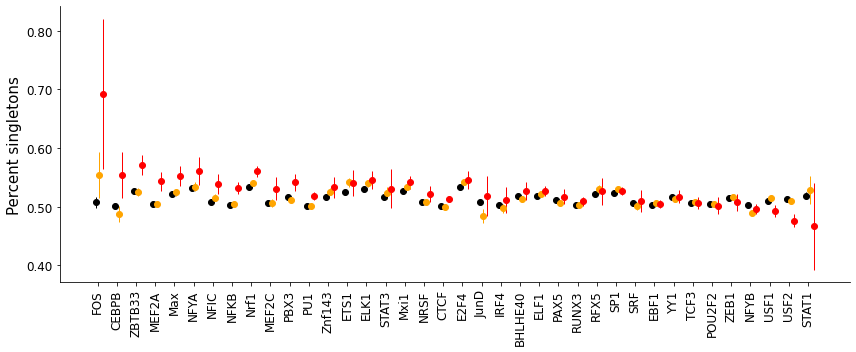

In [9]:
results = results.sort_values("diff.rank.995", ascending=False)
xvals = np.array(range(results.shape[0]))

w = 0.1
fig = plt.figure()
fig.set_size_inches((12, 5))
ax = fig.add_subplot(111)
ax.errorbar(xvals, results["sing.all"], label="All", yerr=results["sing.all.err"], marker="o", linewidth=0, elinewidth=1, color="black")
#ax.errorbar(xvals+w, results["sing.core"], label="core", yerr=results["sing.core.err"], marker="o", linewidth=0, elinewidth=1, color="g")

i=0
x = rank_perc[i]
lab = "Rank"
ax.errorbar(xvals+w*(2+i), results["sing.rank.%s"%x], label=lab, yerr=results["sing.rank.%s.err"%x], marker="o", linewidth=0, elinewidth=1, color="orange")

i=2
x = rank_perc[i]
ax.errorbar(xvals+w*(2+i), results["sing.rank.%s"%x], label=lab, yerr=results["sing.rank.%s.err"%x], marker="o", linewidth=0, elinewidth=1, color="red")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks(xvals+w)
ax.set_xticklabels(results["factor"], rotation=90, size=12, fontname="Arial");
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12, fontname="Arial")
#ax.legend(loc="upper left")
ax.set_ylabel("Percent singletons", size=15, fontname="Arial")
plt.tight_layout()
fig.savefig("singleton_950_995.pdf")

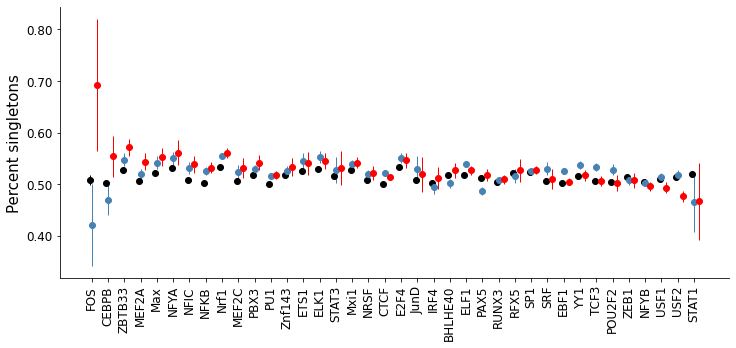

In [10]:
results = results.sort_values("diff.rank.995", ascending=False)
xvals = np.array(range(results.shape[0]))

w = 0.1
fig = plt.figure()
fig.set_size_inches((12, 5))
ax = fig.add_subplot(111)
ax.errorbar(xvals, results["sing.all"], label="All", yerr=results["sing.all.err"], marker="o", linewidth=0, elinewidth=1, color="black")
ax.errorbar(xvals+w, results["sing.core"], label="core", yerr=results["sing.core.err"], marker="o", linewidth=0, elinewidth=1, color="steelblue")
lab = True
for i in [2]:
    x = rank_perc[i]
    if not lab:
        lab = "Rank"
    else:
        lab = ""
    ax.errorbar(xvals+w*(2+i), results["sing.rank.%s"%x], label=lab, yerr=results["sing.rank.%s.err"%x], marker="o", linewidth=0, elinewidth=1, color="red")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks(xvals+w)
ax.set_xticklabels(results["factor"], rotation=90, size=12);
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12)
#ax.legend(loc="upper left")
ax.set_ylabel("Percent singletons", size=15);
fig.savefig("singleton_995_core.pdf")

In [11]:
results_greater = results[results["sing.rank.950"] > results["sing.all"]].sort_values("factor")
print (results_greater.shape[0])
print (results_greater[["factor","sing.rank.950","sing.all"]])

22
    factor  sing.rank.950  sing.all
3     E2F4       0.541804  0.533711
4     EBF1       0.505588  0.502538
5     ELF1       0.522381  0.518138
6     ELK1       0.539708  0.529899
7     ETS1       0.541484  0.524732
8      FOS       0.554217  0.507340
11     Max       0.525025  0.522114
14    Mxi1       0.533489  0.527251
15    NFIC       0.515287  0.508712
16    NFKB       0.505289  0.502973
17    NFYA       0.534110  0.531145
20    NRSF       0.508269  0.508248
19    Nrf1       0.541277  0.532890
24     PU1       0.501578  0.500689
25    RFX5       0.529738  0.521613
27     SP1       0.531085  0.523159
29   STAT1       0.528345  0.518643
30   STAT3       0.523585  0.515856
31    TCF3       0.508778  0.506568
32    USF1       0.515246  0.510356
36    ZEB1       0.516812  0.514087
37  Znf143       0.525369  0.517354


In [12]:
results_greater = results[results["sing.rank.990"] > results["sing.all"]].sort_values("factor")
print (results_greater.shape[0])
print (results_greater[["factor","sing.rank.990","sing.all"]])

28
    factor  sing.rank.990  sing.all
1    CEBPB       0.513158  0.501229
2     CTCF       0.510973  0.500505
3     E2F4       0.553598  0.533711
4     EBF1       0.507981  0.502538
5     ELF1       0.520525  0.518138
6     ELK1       0.554763  0.529899
7     ETS1       0.536842  0.524732
10    JunD       0.537129  0.508286
12   MEF2A       0.527346  0.505426
13   MEF2C       0.525963  0.506062
11     Max       0.532765  0.522114
14    Mxi1       0.545343  0.527251
15    NFIC       0.530265  0.508712
16    NFKB       0.523810  0.502973
17    NFYA       0.555940  0.531145
20    NRSF       0.517892  0.508248
19    Nrf1       0.555199  0.532890
22    PBX3       0.518635  0.516733
23  POU2F2       0.517274  0.504661
24     PU1       0.506962  0.500689
25    RFX5       0.537647  0.521613
27     SP1       0.534228  0.523159
29   STAT1       0.541667  0.518643
30   STAT3       0.532438  0.515856
34     YY1       0.520531  0.515964
35  ZBTB33       0.548434  0.527058
36    ZEB1       0.515106

In [13]:
results_greater = results[results["sing.rank.995"] > results["sing.all"]].sort_values("factor")
print (results_greater.shape[0])
print (results_greater[["factor","sing.rank.995","sing.all"]])

31
     factor  sing.rank.995  sing.all
0   BHLHE40       0.526512  0.517967
1     CEBPB       0.554140  0.501229
2      CTCF       0.513720  0.500505
3      E2F4       0.545794  0.533711
4      EBF1       0.504640  0.502538
5      ELF1       0.526535  0.518138
6      ELK1       0.545200  0.529899
7      ETS1       0.540275  0.524732
8       FOS       0.692308  0.507340
9      IRF4       0.511236  0.502341
10     JunD       0.518692  0.508286
12    MEF2A       0.543131  0.505426
13    MEF2C       0.531014  0.506062
11      Max       0.552347  0.522114
14     Mxi1       0.541481  0.527251
15     NFIC       0.538101  0.508712
16     NFKB       0.532027  0.502973
17     NFYA       0.560920  0.531145
20     NRSF       0.522247  0.508248
19     Nrf1       0.560479  0.532890
21     PAX5       0.517442  0.511109
22     PBX3       0.541597  0.516733
24      PU1       0.518287  0.500689
25     RFX5       0.526427  0.521613
26    RUNX3       0.508949  0.503292
27      SP1       0.527057  0.52315

In [14]:
results_greater = results[results["sing.rank.995"] > results["sing.core"]].sort_values("factor")
print (results_greater.shape[0])
print (results_greater[["factor","sing.core","sing.all"]])

23
     factor  sing.core  sing.all
0   BHLHE40   0.501407  0.517967
1     CEBPB   0.468647  0.501229
8       FOS   0.421053  0.507340
9      IRF4   0.493480  0.502341
12    MEF2A   0.519070  0.505426
13    MEF2C   0.523077  0.506062
11      Max   0.541244  0.522114
14     Mxi1   0.539653  0.527251
15     NFIC   0.530735  0.508712
16     NFKB   0.524765  0.502973
17     NFYA   0.550300  0.531145
20     NRSF   0.519854  0.508248
19     Nrf1   0.554733  0.532890
21     PAX5   0.486568  0.511109
22     PBX3   0.528576  0.516733
24      PU1   0.515838  0.500689
25     RFX5   0.515038  0.521613
26    RUNX3   0.507841  0.503292
27      SP1   0.525085  0.523159
29    STAT1   0.465753  0.518643
30    STAT3   0.528061  0.515856
35   ZBTB33   0.547323  0.527058
37   Znf143   0.524891  0.517354


#### results_greater = results[results["sing.core"] < results["sing.rank.990"]].sort_values("factor")
print (results_greater.shape[0])
print (results_greater[["factor","sing.core","sing.rank.990"]])

for method in ("AgentBind",):
    for f in factors:
        subset = factordata[method][f][factordata[method][f]["AN"] > 8000]
        print ("%s:%d,%d" %(f, factordata[method][f].shape[0], subset.shape[0]))

In [15]:
results[["factor","pval.rank.950","pval.rank.990","pval.rank.995"]]

,factor,pval.rank.950,pval.rank.990,pval.rank.995
8,FOS,0.106446,0.531117,0.090598
1,CEBPB,0.836218,0.337759,0.091720
35,ZBTB33,0.582164,0.054087,0.005585
12,MEF2A,0.564759,0.033081,0.010230
11,Max,0.308800,0.200838,0.039961
17,NFYA,0.346432,0.070302,0.105853
15,NFIC,0.115491,0.042144,0.042537
16,NFKB,0.264256,0.005058,0.003821
19,Nrf1,0.002895,0.000342,0.000977
13,MEF2C,0.508098,0.083335,0.099051


In [16]:
results[["factor","pval.rank.950","pval.rank.990","pval.rank.995"]][results["pval.rank.995"]<0.05]

,factor,pval.rank.950,pval.rank.990,pval.rank.995
35,ZBTB33,0.582164,0.054087,0.005585
12,MEF2A,0.564759,0.033081,0.010230
11,Max,0.308800,0.200838,0.039961
15,NFIC,0.115491,0.042144,0.042537
16,NFKB,0.264256,0.005058,0.003821
19,Nrf1,0.002895,0.000342,0.000977
22,PBX3,0.889784,0.428234,0.041686
24,PU1,0.353260,0.120775,0.009050
2,CTCF,0.851219,0.000817,0.001778


In [17]:
# calculate overall p-value
fd = pd.concat(factordata.values())

cols = ["factor","sing.all","sing.core","n.all","n.core","pval.core"]
for i in range(len(rank_perc)):
    cols.extend(["sing.rank.%s"%rank_perc[i], "sing.rank.%s.err"%rank_perc[i], "pval.rank.%s"%rank_perc[i],
                 "num.%s"%rank_perc[i]])
data = []


p_all = np.mean(fd["sing"])
p_core = np.mean(fd[fd["core"]>0]["sing"])
n_all = fd.shape[0]
n_core = fd[fd["core"]>0].shape[0]
d = ["ALL", p_all, p_core, n_all, n_core]

# Get pval for core
n_not_core = n_all-n_core
p_not_core = (p_all*n_all-p_core*n_core)/(n_not_core)
se_core = np.sqrt(p_all*(1-p_all)*(1.0/n_core+1.0/n_not_core))
pval_core = 1-scipy.stats.norm.cdf((p_core-p_not_core)/se_core)
d.append(pval_core)
    
for i in range(len(rank_perc)):
    rk = (fd[fd["rank"]>=rank_perc[i]]["sing"])
    p_rk = np.mean(rk)
    err_rk = np.sqrt(p_rk*(1-p_rk)/len(rk))
    n_rk = len(rk)
    n_not_rk = n_all-n_rk
    p_not_rk = (p_all*n_all-np.sum(rk))*1.0/n_not_rk
    # Compute pvals
    se_rk = np.sqrt(p_all*(1-p_all)*(1.0/n_rk+1.0/n_not_rk))
    pval_rk = 1-scipy.stats.norm.cdf((p_rk-p_not_rk)/se_rk)
    # Add data
    d.extend([p_rk, err_rk, pval_rk, len(rk)])
data.append(d)

result_all = pd.DataFrame(data, columns=cols)
result_all["sing.all.err"] = result_all.apply(lambda x: np.sqrt(x["sing.all"]*(1-x["sing.all"])/x["n.all"]), 1)
result_all["sing.core.err"] = result_all.apply(lambda x: np.sqrt(x["sing.core"]*(1-x["sing.core"])/x["n.core"]), 1)

In [18]:
result_all.transpose()

,0
factor,ALL
sing.all,0.50969
sing.core,0.523063
n.all,9099752
n.core,173897
pval.core,0
sing.rank.950,0.511343
sing.rank.950.err,0.000641596
pval.rank.950,0.00383713
num.950,607006


In [19]:
print ((results["diff.rank.950"]).sum()/38.0)
print ((results["diff.rank.990"]).sum()/38.0)
print ((results["diff.rank.995"]).sum()/38.0)

0.002188885088414133
0.00894872489933847
0.015479544894927758


In [22]:
results[results["pval.rank.995"] < 0.05/38][["factor","pval.rank.950","pval.rank.990","pval.rank.995"]]

,factor,pval.rank.950,pval.rank.990,pval.rank.995
19,Nrf1,0.002895,0.000342,0.000977


In [21]:
results[results["pval.rank.995"] < 0.05][["factor","pval.rank.950","pval.rank.990","pval.rank.995"]]

,factor,pval.rank.950,pval.rank.990,pval.rank.995
35,ZBTB33,0.582164,0.054087,0.005585
12,MEF2A,0.564759,0.033081,0.010230
11,Max,0.308800,0.200838,0.039961
15,NFIC,0.115491,0.042144,0.042537
16,NFKB,0.264256,0.005058,0.003821
19,Nrf1,0.002895,0.000342,0.000977
22,PBX3,0.889784,0.428234,0.041686
24,PU1,0.353260,0.120775,0.009050
2,CTCF,0.851219,0.000817,0.001778
